In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import operator
import scipy.spatial.distance as distance
from sklearn import metrics 
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import fastparquet

In [2]:
df = pd.read_pickle('processed_df.pkl')
ratings = pd.read_pickle('ratings_sample.pkl')
ratings = ratings.reset_index()
movies_raitings = pd.read_parquet('movies_ratings.parq')
movies_raitings = movies_raitings.rename(columns={"avg": "Average_Ratings"})

In [3]:
movies = df.drop(columns = ['movieId', 'title_eng', 'year'])

## Build Recommendations for 1 User
To Do:
- Extend to all users (function) -done
- Test/train split so hold out some recommendations to evaluate against --> evaluate

Extensions:
- Include year (decade)?
- Include text from description or genome tags
- Downweight older ratings 

Modification/Addition:

- Added Personalization
- Added Average Raitings with User Recommendation
- Added precision at k, recaall at k
- Added personal diversity

In [48]:
# limit to one user
ratings_user = ratings[ratings.userId == 100]
movies_user = df[df.movieId.isin(ratings_user.movieId.unique())]
# keep track of movies already watched
watched = movies_user.movieId.unique()

movies_user = movies_user.drop(columns = ['movieId', 'title_eng', 'year'])

In [49]:
# normalize ratings: subtract mean rating  from ratings
# if rating < mean, normalized rating will be negative. Which is worse than 0 aka not rating movie at all.

#### should this be averaged??

mean_rating = np.mean(ratings_user.rating)
ratings_user.rating = ratings_user.rating - mean_rating


/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
# create user profile: multiply item profile by user ratings --> sum of ratings for each attribute 
profile = movies_user.T.dot(ratings_user.rating.values)

In [12]:
# cosine similarity between movie and user profile 
movies = df.drop(columns = ['movieId', 'title_eng', 'year'])
recommendations = metrics.pairwise.cosine_similarity(movies, np.asmatrix(profile.values))

In [13]:
recommendations = pd.DataFrame(recommendations)
recommendations.columns = ['prediction']

# merge to get title
recommendations = pd.merge(recommendations, df[['title_eng', 'movieId']], left_index = True, right_index = True, how = 'left')

# sort 
recommendations = recommendations.sort_values('prediction', ascending = False)

In [14]:
# remove recommendations already watched
recommendations = recommendations[~recommendations.movieId.isin(watched)]

In [20]:
# movies with the same prediction -- should we secondarily sort by overall popularity of the movie?
recommendations.shape

(44986, 3)

In [51]:
def user_content_recommendations(user_id):   
    """
    ratings_user: limit to one user
    
    movies_user: movies rated by that user
    
    watched: keep track of movies already watched
    
    normalize ratings: subtract mean rating  from ratings
                       if rating < mean, normalized rating will be negative. Which is worse than 0 aka not rating movie at all.
    
    profile:create user profile: multiply item profile by user ratings --> sum of ratings for each attribute 
    
    recommendations: cosine similarity between movie and user profile 
                     merge to get title
                     sort
                     remove recommendations already watched
    """

    ratings_user = ratings[ratings.userId == user_id]
    movies_user = df[df.movieId.isin(ratings_user.movieId.unique())]
    watched = movies_user.movieId.unique()
    movies_user = movies_user.drop(columns = ['movieId', 'title_eng', 'year'])
    
    mean_rating = np.mean(ratings_user.rating)
    ratings_user.rating = ratings_user.rating - mean_rating
    
    profile = movies_user.T.dot(ratings_user.rating.values)
    
    movies = df.drop(columns = ['movieId', 'title_eng', 'year'])
   
    recommendations = metrics.pairwise.cosine_similarity(movies, np.asmatrix(profile.values))
    recommendations = pd.DataFrame(recommendations)
    recommendations.columns = ['prediction']
    recommendations = pd.merge(recommendations, df[['title_eng', 'movieId']], left_index = True, right_index = True, how = 'left')
    recommendations = recommendations.sort_values('prediction', ascending = False)
    recommendations = recommendations[~recommendations.movieId.isin(watched)]
    recommen_ratings = pd.merge(recommendations,movies_raitings)
    return recommen_ratings

def user_top(movies,n):
    return movies[['title_eng','Average_Ratings']][:n]

def user_movie_id(movies,n):
    return movies['movieId'][:n]

def user_avg_rating(movies,n):
    return movies['Average_Ratings'][:n]

### Getting top 10 and top 5 recommendation for user_id = 100 with Average Ratings

In [95]:
userId=93000
recommendation = user_content_recommendations(userId)

/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [96]:
# Get the top 10 Movie recommendation for the user
user_top(recommendation,10)

,title_eng,Average_Ratings
0,"House of the Spirits, The (1993)",3.278157
1,"Legend of Zorro, The (2005)",3.070492
2,Life Itself (2018),3.500000
3,Under the Eiffel Tower (2019),3.000000
4,Forget Me Not (2010),3.333333
5,SPF-18 (2017),0.750000
6,Seducing Mr. Perfect (2006),3.000000
7,The Guest House (2012),1.000000
8,Virgin Snow (2007),2.000000
9,Water Boyy (2015),0.500000


In [97]:
# Get the top 5 Movie recommendation for the user
user_top(recommendation,5)

,title_eng,Average_Ratings
0,"House of the Spirits, The (1993)",3.278157
1,"Legend of Zorro, The (2005)",3.070492
2,Life Itself (2018),3.500000
3,Under the Eiffel Tower (2019),3.000000
4,Forget Me Not (2010),3.333333


## Evaluation: Personalization



In [35]:
"""
get_users_prediction: returns user prediction

user_matrix: generated user by movies, 0: movie not recommended, 1: movie got recommended

"""
def get_users_prediction(users_list,top_n,users_prediction):
    for i in users_list:
        recommendation = user_content_recommendations(i)
        prediction = user_movie_id(recommendation,top_n).astype(int).values
        users_prediction = users_prediction.append(pd.Series(prediction),ignore_index=True)
        
    return users_prediction

def user_matrix(users_pred):
    data_melt= pd.DataFrame(data=users_pred).reset_index().melt(id_vars='index', value_name='movieId',)
    data_melt = data_melt[['index', 'movieId']].pivot(index='index', columns='movieId', values='movieId')
    cols = data_melt.columns
    for i in cols:
        data_melt[i] = np.where(data_melt[i].isna(), 0, 1)
    return data_melt


def personalization(users_matrix,n):
    # generating cosine similarity between the users
    #then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
    #calculating the avg of the element above diagonal 
    #Personalization means 1 - similarity
    #higher the personalization score, better the recommendation system in recommending personalized movies
   
    users_sim = metrics.pairwise.cosine_similarity(users_matrix)
    iu1 = np.triu_indices(n,k=1)
    similarity_avg = np.mean(users_sim[iu1])
    personalization_score = 1 - similarity_avg

    return personalization_score

def cross_fold_eval(unique_users,k_fold=5,n=5,top_n=10):
    #users_list: List of random n users
    
    kfold_personalization=0
    for i in range(k_fold):
        users_list = random.sample(unique_users, n)
        
        #columns: top_n recommendations
        #users_prediction:  top_n recommendations for n users
        column_names = list(range(top_n))
        users_prediction = pd.DataFrame(columns = column_names)
        
        # getting predictions for sampled users
        users_pred = get_users_prediction(users_list,top_n,users_prediction)
        
        # getting user by movies matrix with binary indicators 0: movie not recommended, 1: movie got recommended
        users_matrix = user_matrix(users_pred)
        kfold_personalization+=personalization(users_matrix,n)
    kfold_eval = kfold_personalization/k_fold
    print(f'Personalization score for {k_fold} k_fols validation: {kfold_eval}')
        

In [36]:
"""
    unique_users: getting unique user set 
    
    default values given in function
    n: number of users (5)
    top_n: top number of recommendations (10)
"""

unique_users = set(ratings.userId)
start_time = time.time()
cross_fold_eval(unique_users)

end_time = time.time() - start_time
print(f'Time take {end_time} seconds')
    
    





/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Personalization score for 5 k_fols validation: 1.0
Time take 964.5071740150452 seconds


# Precision and Recall 

### Keeping the users who have rated minimum of 20 movies

In [10]:
user_list = ratings.groupby('userId')['userId'].count().reset_index(name="rating_count")

In [39]:
users_list = set(user_list[user_list['rating_count']>=20]['userId'].values)

In [40]:
print(f' Number of users who rated at least 20 movies: {len(users_list)}')

 Number of users who rated at least 20 movies: 115856


In [41]:
n_users = 1000
random_users = random.sample(users_list, n_users)

In [42]:
users_ratings = ratings[ratings.userId.isin(random_users)]

In [43]:
len(users_ratings)

94364

### train/test split - Keeping the users distribution similar

In [44]:
# creating train/test empty dataframe

train = pd.DataFrame(columns=['index','userId', 'movieId', 'rating','timestamp'])
test = pd.DataFrame(columns=['index','userId', 'movieId', 'rating','timestamp'])

In [45]:
# spliting each user data equally in train test
for i in random_users:
    #getting individual user index
    random_index =set(users_ratings[users_ratings['userId'] == i].index.values)
    
    # dividing the user ratings count/2
    n_len = np.math.floor(len(random_index)/2)
    

    # getting index for train data
    train_ind = set(random.sample(random_index, n_len))

    # getting index for test data by removing train index from all index for that user
    test_ind = set(random_index-train_ind)
    

    # getting data for that user
    df_train = users_ratings.loc[train_ind]
    df_test = users_ratings.loc[test_ind]
    # appending that user data to train/test df
    
    train = train.append(df_train)
    test = test.append(df_test)

#### Train Records

In [46]:
train.shape

(46937, 5)

#### Test Records

In [47]:
test.shape

(47427, 5)

#### random sample a user from train set

In [48]:
train_user_id = set(train.userId.values)
random_userId = random.sample(train_user_id, 1)
random_userId[0]

70527

## get recommendations for the user

In [49]:
recommendation = user_content_recommendations(random_userId[0])
user_top(recommendation,10)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,title_eng,Average_Ratings
0,High Lane (2009),3.000000
1,Fury: The Tales of Ronan Pierce (2014),5.000000
2,Jaws 3-D (1983),1.828405
3,Extinction (2014),1.000000
4,Robin Hood (2018),2.587500
5,A Viking Saga: The Darkest Day (2013),5.000000
6,On Deadly Ground (1994),1.919118
7,Tough Luck (2004),2.000000
8,Soldiers of Fortune (2012),2.636364
9,Contract Killers (2009),2.666667


## Precision@k  and Recall @k


### Relevant item: Has in test with rating >= 3
### Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

### Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)

In [59]:
# giving k
k =20

# getting the recommended movies @k
recommended_movies = set(recommendation[:k].movieId)

# number of recommended movie @k
recommended_count = k

In [60]:
# getting relevant movies, where ratings >=3.5

relevant_movies =set(test[(test['userId']==random_userId[0]) & (test['rating']>=3) ]['movieId'].values)

In [61]:
# Total number of relevant movie
relevant_count = len(relevant_movies)

In [62]:
# Getting movies that are relevant and recommended
recommended_relevant_movies = recommended_movies.intersection(relevant_movies)

In [63]:
# number of relevant recommended movies
recommended_relevant_count = len(recommended_relevant_movies)

In [65]:
print(f'K : {k}\n')
print(f'Number of recommended movie @ k: {recommended_count} \n')
print(f'Number of relevant movie: {relevant_count} from test set \n')
print(f'Number of recommended movies that are relevent @ k: {recommended_relevant_count}\n')

K : 5

Number of recommended movie @ k: 5 

Number of relevant movie: 10 from test set 

Number of recommended movies that are relevent @ k: 0



In [66]:
def calc_precision_k(recommended_relevant_count,recommended_count):
    precision_k = recommended_relevant_count/recommended_count
    return precision_k

def calc_recall_k(recommended_relevant_count,relevant_count):
    if relevant_count==0:
        return 0
    else:
        recall_k = recommended_relevant_count/relevant_count
        return recall_k

In [67]:
precision_k = calc_precision_k(recommended_relevant_count,recommended_count)
print(f' Precision at {k} is: {precision_k} ')

 Precision at 5 is: 0.0 


In [58]:
recall_k = calc_recall_k(recommended_relevant_count,relevant_count)
print(f' Recall at {k} is: {recall_k}')

 Recall at 5 is: 0.0


# Diversity

## Personal Diversity: 

### Calculate for n users and then do an average.


In [25]:
def personal_diversity(top_n,n,list_user):
    rand_user = random.sample(list_user, n)  
    length = len(rand_user)
    # storing diversity for n users
    diversity =[]
    for u in range(length):
        # getting recommended movies
        recommendation = user_content_recommendations(rand_user[u])
        prediction = user_movie_id(recommendation,top_n).astype(int).values
        user_df = df[df.movieId.isin(prediction)]
        user_movie_features = pd.DataFrame()
        cols = user_df.columns.values
        
        # getting only the columns that have any value 1
        for i in range(3,len(cols)):
            if (np.any(user_df.iloc[:,i])==1):
                
                user_movie_features[cols[i]] = user_df.iloc[:,i]
        
        # generating cosine similarity between the users
        #then getting the indicies of elements above diagonal (giving diagonal offsert =1 in triu_indices)
        #calculating the avg of the element above diagonal 
        sim = metrics.pairwise.cosine_similarity(np.asmatrix(user_movie_features))

        iu1 = np.triu_indices(user_movie_features.shape[0],k=1)
        avg = 1 - np.mean(sim[iu1])
        
        print(f'Diversity of movies recommended for user {rand_user[u]}: {avg}')
        diversity.append(avg)
        
    # calculating avg diversity over n users
    avg_diversity = np.mean(diversity)
    print(avg_diversity)
    print(f'Average diversity over {n} users : {avg_diversity}')

In [26]:
"""
top_n: top n recommendations
n: number of users

Ignore warning for now - comming from recommendatiom function
Fixed the one from this function
"""

top_n = 5
n = 10
list_user = set(ratings.userId)

personal_diversity(top_n,n,list_user)
# function call for personal diversity

/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Diversity of movies recommended for user 106385: 2.220446049250313e-16


/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Diversity of movies recommended for user 52285: -2.220446049250313e-16
0.0
Average diversity over 2 users : 0.0


## Average Rating 


### Get average rating for n users

1) Getting the top_n ratings of movies recommended to n users.

2) Averaging over the all the ratings

In [134]:
"""
n: number of users
top_n: top n movie recommendations

"""

list_user = set(ratings.userId)
n = 5
top_n = 10

In [135]:
rand_user = random.sample(list_user, n)  
length = len(rand_user)
top_n
avg_rating = []
for u in range(length):
    # getting recommended movies
    recommendation = user_content_recommendations(rand_user[u])
    prediction = user_avg_rating(recommendation,top_n).values
    avg_rating.append(prediction)

/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [163]:
print(f'Average movie rating of top {top_n} movies recommended to {n} users is: {np.round(np.mean(avg_rating),2)}')

Average movie rating of top 10 movies recommended to 5 users is: 3.0


In [165]:
ranges = ['0-1', '1-2', '2-3', '3-4', '4-5']
ad = pd.DataFrame(avg_rating).melt()
ad['ratingrange'] = pd.cut(ad['value'], bins=[0,1,2,3,4,5], labels=ranges, right=True)


Text(0.5, 1.0, 'Ratings - Recommended Movies')

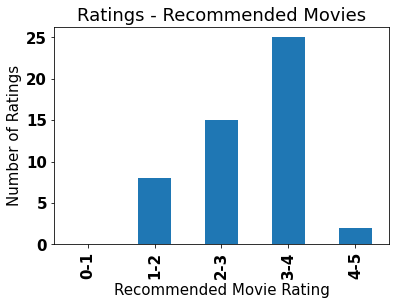

In [168]:
font = {'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

ax = ad.groupby(['ratingrange'])['ratingrange'].count().plot.bar()
ax.set_ylabel('Number of Ratings')
ax.set_xlabel('Recommended Movie Rating')
ax.set_title('Ratings - Recommended Movies')

# Checking for the long tail

- to check are we recommending unpopular movies?

In [201]:
n =20
top_n =10
rand_user = random.sample(list_user, n)  
length = len(rand_user)
top_n
min_cnt = []

for u in range(length):
    # getting recommended movies
    recommendation = user_content_recommendations(rand_user[u])
    
    # getting the min rating cnt of the movies recommended
    min_rating_cnt = recommendation[:top_n]['cnt'].min()
    min_cnt.append(min_rating_cnt)

avg_min_cnt = np.mean(min_cnt)

/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/envs/Peritia1/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [203]:
print(f'Average of the long tail movies in our recommendation system {np.round(avg_min_cnt,2)}')

Average of the long tail movies in our recommendation system 1.1
